In [1]:
import os
import cv2
import random
import numpy as np
from collections import Counter
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, SMOTENC
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Activation, Flatten, Dropout, BatchNormalization, Conv2D
from keras.layers import AveragePooling2D, Dense, Input, Lambda, concatenate

Using TensorFlow backend.


In [2]:
# Goal: 60% train, 20% validate, 20% test -> 80% train+validate, 20% test

folders = sorted(os.listdir("data_organized"))
train_val_patients = []
test_patients = []
test_count = 0
random.shuffle(folders)

for name in folders:
    train_val_patients.append(name)
    
for name in folders:
    _, count = name.split('+')
    # Fill up test_patients with 62 first
    count = int(count)
    if test_count+count <= 62:
        test_patients.append(name)
        test_count += count
        train_val_patients.remove(name)
        if test_count == 62:
            break
    elif test_count+count > 62:
        continue
        
print(test_count)

62


In [3]:
# Read in files from folders, process images, T2 size, zone info, labels
# clinsig TRUE = 1, FALSE = 0

X_img_t2 = []
X_img_adc = []
X_size_t2 = []
X_size_adc = []
X_zone = []
y = []

for folder in train_val_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        if zone == 'SV': # only 2 data points have this zone
            continue
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array_gray = np.asarray(img)
        array = cv2.merge((array_gray,array_gray,array_gray)) 
        if adc_t2 == 't2':
            X_img_t2.append(array)
            X_size_t2.append(int(size))
            X_zone.append(zone)
            if label == 'TRUE':
                y.append(1)
            else:
                y.append(0)
        else:
            X_img_adc.append(array)
            X_size_adc.append(int(size))
            

# one-hot encode zones, which are categorical features: AS=100, PZ=010, TZ=001
X_zone = LabelBinarizer().fit_transform(X_zone)

# [0,1] min-max T2 size, which are continuous features
X_size_t2 = MinMaxScaler().fit_transform(np.array(X_size_t2).reshape(-1,1))
X_size_adc = MinMaxScaler().fit_transform(np.array(X_size_adc).reshape(-1,1))

In [4]:
X_img_t2 = np.array(X_img_t2)
X_img_adc = np.array(X_img_adc)
y = np.array(y)
print('Original: indolent={}, clinsig={}'.format(Counter(y)[0], Counter(y)[1]))

num, d1, d2, channels = X_img_t2.shape
X_img_t2 = X_img_t2.reshape(num, d1*d2*channels)

num, d1, d2, channels = X_img_adc.shape
X_img_adc = X_img_adc.reshape(num, d1*d2*channels)

X = np.column_stack((X_img_t2, X_img_adc))
X = np.column_stack((X, X_size_t2))
X = np.column_stack((X, X_size_adc))
X = np.column_stack((X, X_zone))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled: indolent={}, clinsig={}\n'.format(Counter(y_res)[0], Counter(y_res)[1]))
print('Flattened: X_res.shape={}, y_res.shape={}]\n'.format(X_res.shape, y_res.shape))

len_img_flag = int((X_res.shape[1]-5)/2)
X_img_t2 = X_res[:,:len_img_flag]
X_img_adc = X_res[:,len_img_flag:-5]
X_size_t2 = X_res[:,-4] # 1 column
X_size_adc = X_res[:,-3] # 1 column
X_zone = X_res[:,-2:] #3 columns
y = y_res[:]
num_new, flat_dim = X_img_t2.shape #should be same for adc

X_img_t2 = X_img_t2.reshape(num_new, d1*d2*channels).reshape(num_new, d1, d2, channels)
X_img_adc = X_img_adc.reshape(num_new, d1*d2*channels).reshape(num_new, d1, d2, channels)

print('X_img_t2.shape={}'.format(X_img_t2.shape))
print('X_img_adc.shape={}'.format(X_img_adc.shape))
print('X_size_t2.shape={}'.format(X_size_t2.shape))
print('X_size_adc.shape={}'.format(X_size_adc.shape))
print('X_zone.shape={} \ny.shape={}'.format(X_zone.shape, y.shape))

Original: indolent=194, clinsig=60
Resampled: indolent=194, clinsig=194

Flattened: X_res.shape=(388, 6149), y_res.shape=(388,)]

X_img_t2.shape=(388, 32, 32, 3)
X_img_adc.shape=(388, 32, 32, 3)
X_size_t2.shape=(388,)
X_size_adc.shape=(388,)
X_zone.shape=(388, 2) 
y.shape=(388,)


In [5]:
# Now split this into training and validation set
X = list(zip(X_img_t2, X_img_adc, X_size_t2, X_size_adc, X_zone))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=2)
X_img_t2_train, X_img_adc_train, X_size_t2_train, X_size_adc_train, X_zone_train = zip(*X_train)
X_img_t2_val, X_img_adc_val, X_size_t2_val, X_size_adc_val, X_zone_val = zip(*X_val)

ntrain = len(X_img_t2_train) # = len(X_size_train) = len(X_zone_train), same for adc
nval = len(X_img_t2_val) # = len(X_size_val) = len(X_zone_val), same for adc
print("ntrain={}, nval={}".format(ntrain, nval))

ntrain=291, nval=97


In [6]:
def create_cnn(width=32, height=32, depth=3):
    chanDim = 3
    input_tensor = Input(shape=(32, 32, 3))
    conv_base = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
    conv_base.trainable = False
    x = conv_base.output
    
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Activation("relu")(x)
    
    for i in range(9):
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Activation("relu")(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = BatchNormalization(axis=chanDim)(x)
    
    x = AveragePooling2D(pool_size=(3,3), padding="same")(x)
    
    model = Model(input_tensor, x)
    return model

# def output_size():
#     inp = Input(shape=(1))
#     out = Lambda(lambda x: x, output_shape=(1))(inp)
#     model = Model(inp, out)
    
# def output_zone():
#     inp = Input(shape=(1,3))
#     out = Lambda(lambda x: x, output_shape=(1,3))(inp)
#     model = Model(inp, out)

In [7]:
cnn_t2 = create_cnn()
cnn_adc = create_cnn()
# dummy_size = output_size()
# dummy_zone = output_zone()

for layer in cnn_t2.layers:
    layer.name = layer.name + str("_t2")
for layer in cnn_adc.layers:
    layer.name = layer.name + str("_adc")

combinedInput = concatenate([cnn_t2.output, cnn_adc.output])

x = combinedInput
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dense(1, activation="sigmoid", name='predictions')(x)

model = Model(inputs=[cnn_t2.input, cnn_adc.input], outputs=x)
# model.summary()

/home/stephaniekdoan/.local/lib/python3.5/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [8]:
opt = tf.keras.optimizers.RMSprop(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

In [12]:
batch_size = 64

img_datagen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=[0.7,1],
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

def generate_generator_multiple(generator, x_t2, x_adc, y, batch):
    genX1 = generator.flow(x_t2, y, batch_size=batch)
    genX2 = generator.flow(x_adc, y, batch_size=batch)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label
            
X_img_t2_train = np.array(X_img_t2_train)
X_img_adc_train = np.array(X_img_adc_train)
y_train = np.array(y_train)
np.asarray(y_train).astype('float32').reshape((-1,1))

X_img_t2_val = np.array(X_img_t2_val)
X_img_adc_val = np.array(X_img_adc_val)
y_val = np.array(y_val)
np.asarray(y_val).astype('float32').reshape((-1,1))

img_train_generator = generate_generator_multiple(generator=img_datagen, 
                                                  x_t2=X_img_t2_train, 
                                                  x_adc=X_img_adc_train,
                                                  y=y_train,
                                                  batch=batch_size)
img_val_generator = generate_generator_multiple(generator=val_datagen, 
                                                x_t2=X_img_t2_val, 
                                                x_adc=X_img_adc_val, 
                                                y=y_val,
                                                batch=batch_size)

# train_generator = train_datagen.flow(X_train_img, y_train, batch_size=batch_size)
# val_generator = val_datagen.flow(X_val_img, y_val, batch_size=batch_size)

In [11]:
history = model.fit_generator(img_train_generator,
                              steps_per_epoch=ntrain//batch_size,
                              epochs=170,
                              validation_data=img_val_generator,
                              validation_steps=nval//batch_size)

Epoch 1/170
4/4 [==============================] - 11s 3s/step - loss: 0.7082 - acc: 0.4581 - val_loss: 0.6931 - val_acc: 0.6094
Epoch 2/170
4/4 [==============================] - 11s 3s/step - loss: 0.6963 - acc: 0.5154 - val_loss: 0.6931 - val_acc: 0.5152
Epoch 3/170
4/4 [==============================] - 11s 3s/step - loss: 0.6971 - acc: 0.4714 - val_loss: 0.6931 - val_acc: 0.5625
Epoch 4/170
4/4 [==============================] - 11s 3s/step - loss: 0.7086 - acc: 0.5198 - val_loss: 0.6930 - val_acc: 0.6061
Epoch 5/170
4/4 [==============================] - 12s 3s/step - loss: 0.7023 - acc: 0.4844 - val_loss: 0.6930 - val_acc: 0.5781
Epoch 6/170
4/4 [==============================] - 11s 3s/step - loss: 0.6949 - acc: 0.5683 - val_loss: 0.6930 - val_acc: 0.5758
Epoch 7/170
4/4 [==============================] - 11s 3s/step - loss: 0.7012 - acc: 0.4934 - val_loss: 0.6929 - val_acc: 0.5938
Epoch 8/170
4/4 [==============================] - 11s 3s/step - loss: 0.7052 - acc: 0.4802 - val

4/4 [==============================] - 11s 3s/step - loss: 0.6844 - acc: 0.5551 - val_loss: 0.6969 - val_acc: 0.4242
Epoch 65/170
4/4 [==============================] - 12s 3s/step - loss: 0.7042 - acc: 0.4688 - val_loss: 0.6915 - val_acc: 0.5469
Epoch 66/170
4/4 [==============================] - 11s 3s/step - loss: 0.6841 - acc: 0.5419 - val_loss: 0.6885 - val_acc: 0.6364
Epoch 67/170
4/4 [==============================] - 11s 3s/step - loss: 0.7082 - acc: 0.5110 - val_loss: 0.6910 - val_acc: 0.5469
Epoch 68/170
4/4 [==============================] - 11s 3s/step - loss: 0.6746 - acc: 0.5419 - val_loss: 0.6878 - val_acc: 0.6364
Epoch 69/170
4/4 [==============================] - 11s 3s/step - loss: 0.6847 - acc: 0.5286 - val_loss: 0.6892 - val_acc: 0.5781
Epoch 70/170
4/4 [==============================] - 12s 3s/step - loss: 0.7007 - acc: 0.4922 - val_loss: 0.6887 - val_acc: 0.5758
Epoch 71/170
4/4 [==============================] - 11s 3s/step - loss: 0.6930 - acc: 0.5154 - val_loss

Epoch 127/170
4/4 [==============================] - 11s 3s/step - loss: 0.6926 - acc: 0.5022 - val_loss: 21.0784 - val_acc: 0.4531
Epoch 128/170
4/4 [==============================] - 11s 3s/step - loss: 0.7017 - acc: 0.5066 - val_loss: 25.5202 - val_acc: 0.3636
Epoch 129/170
4/4 [==============================] - 11s 3s/step - loss: 0.6928 - acc: 0.5022 - val_loss: 24.1492 - val_acc: 0.3906
Epoch 130/170
4/4 [==============================] - 12s 3s/step - loss: 0.6994 - acc: 0.5117 - val_loss: 22.3510 - val_acc: 0.4848
Epoch 131/170
4/4 [==============================] - 11s 3s/step - loss: 0.6698 - acc: 0.5683 - val_loss: 22.8574 - val_acc: 0.4375
Epoch 132/170
4/4 [==============================] - 11s 3s/step - loss: 0.7049 - acc: 0.4758 - val_loss: 27.3644 - val_acc: 0.3939
Epoch 133/170
4/4 [==============================] - 11s 3s/step - loss: 0.6890 - acc: 0.5330 - val_loss: 22.6378 - val_acc: 0.4531
Epoch 134/170
4/4 [==============================] - 11s 3s/step - loss: 0.6

In [13]:
model.save_weights('models/model_t2+adc_weights.h5')
model.save('models/model_t2+adc_keras.h5')

/home/stephaniekdoan/.local/lib/python3.5/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


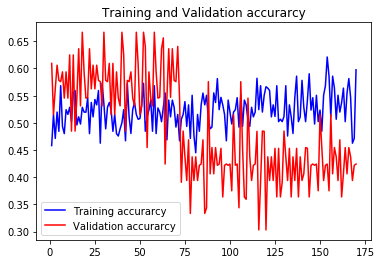

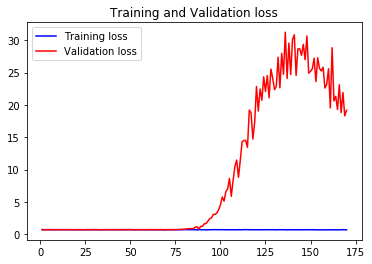

In [14]:
# Plot validation and losss

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

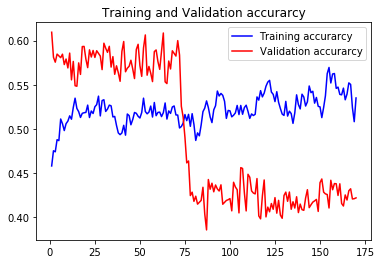

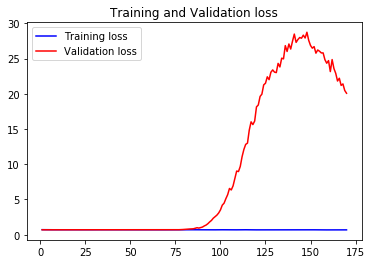

In [15]:
# Plot validation and losss with smoother lines

def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

#Plot figure
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accurarcy')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.show()

plt.plot(epochs, smooth_plot(loss), 'b', label='Training loss')
plt.plot(epochs, smooth_plot(val_loss), 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [16]:
#Prepare test set

X_t2_test = []
X_adc_test = []
y_test = []

for folder in test_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array_gray = np.asarray(img)
        array = cv2.merge((array_gray,array_gray,array_gray))  
        if adc_t2 == 't2':
            X_t2_test.append(array)
            if label == 'TRUE':
                y_test.append(1)
            else:
                y_test.append(0)
        else:
            X_adc_test.append(array)

In [33]:
x_t2 = np.array(X_t2_test)
x_adc = np.array(X_adc_test)
y = np.array(y_test)
total = len(y)

clinsig_pred = 0
correct = 0
false_pos = 0
false_neg = 0

test_datagen = ImageDataGenerator(rescale=1./255)

def generate_generator_multiple(generator, x_t2, x_adc, y, batch):
    genX1 = generator.flow(x_t2, y, batch_size=batch)
    genX2 = generator.flow(x_adc, y, batch_size=batch)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label

test_generator = generate_generator_multiple(generator=test_datagen, x_t2=x_t2, x_adc=x_adc, y=y, batch=1)

predictions = model.predict_generator(test_generator, steps=total)
for i, pred in enumerate(predictions):
    prediction = 1 if pred[0] > 0.5 else 0
    actual = 1 if y[i] == 1 else 0
    if prediction == actual:
        correct += 1
    else:
        if prediction == 1 and actual == 0:
            false_pos += 1
        else:
            false_neg += 1
    clinsig_pred += prediction

print('ACCURACY: {}%'.format(correct/total * 100))
print('FALSE POSITIVE: {}%'.format(false_pos/(total-correct)))
print('FALSE NEGATIVE: {}%'.format(false_neg/(total-correct)))
print('CLINICALLY SIGNIFICANT PREDICTION: {}%'.format(clinsig_pred/total))

ACCURACY: 24.193548387096776%
FALSE POSITIVE: 1.0%
FALSE NEGATIVE: 0.0%
CLINICALLY SIGNIFICANT PREDICTION: 0.9838709677419355%
